<h2>Table of Contents</h2>
<li><h4><a href="#imp">1.1 Import packages</a></h4></li>
<li><h4><a href="#load">1.2 Load data</a></h4></li>
<li><h4><a href="#split">1.3 Train-test split</a></h4></li>
<li><h4><a href="#scale">1.4 Scale robustly</a></h4></li>
<li><h4><a href="#default">2. Test default models</a></h4></li>
<li><h4><a href="#top3">2.1 Select top 3</a></h4></li>

This is the attempt to predict the price of an Airbnb with preprocessed dataset of which all missing values were eliminated.
<a id="imp"></a><h2>1.1 Import packages</h2>

In [69]:
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.integration import LightGBMPruningCallback
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

<a id="imp"></a><h2>1.2 Load data</h2>

In [70]:
with open('airbnb_data_no_na.pickle', 'rb') as file:
    df = pickle.load(file)

<a id="split"></a><h2>1.3 Train-test split</h2>

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],  # Features (excluding the target column)
                                                    df.iloc[:, -1],   # Target variable (last column)
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

<a id="scale"></a><h2>1.4 Scale robustly</h2> 

In [72]:
# Initialize the scaler
scaler = RobustScaler()

# Scale X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<a id="default"></a><h2>2. Test default regressors</h2> 

In [73]:
list_models = [LinearRegression(), RandomForestRegressor(), SVR(), XGBRegressor(), GradientBoostingRegressor(),
               ElasticNet(), SGDRegressor(), BayesianRidge(), LGBMRegressor()]
list_model_names = ['Linear Regression', 'Random Forest Regression', 'Support Vector Regression', 'XGB Regression',
                    'Gradient Boosting Regression', 'Elastic Net', 'Stochastic Gradient Descent Regression',
                    'Bayesian Ridge', 'Light GBM Regressor']
score_dict = {model_name: {'rmse': None, 'mae': None} for model_name in list_model_names}

for i, model in enumerate(list_models):
    model_name = list_model_names[i]
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    score_dict[model_name]['rmse'] = rmse
    score_dict[model_name]['mae'] = mae
    
    print(f'{model_name} RMSE: {rmse}')
    print(f'{model_name} MAE: {mae}')

Linear Regression RMSE: 151972880215.0681
Linear Regression MAE: 19172153357.672485
Random Forest Regression RMSE: 90.98350450993455
Random Forest Regression MAE: 60.11131386861314
Support Vector Regression RMSE: 126.95038478409195
Support Vector Regression MAE: 83.31630769587296
XGB Regression RMSE: 92.96579920101024
XGB Regression MAE: 60.14745030512526
Gradient Boosting Regression RMSE: 91.38723482581734
Gradient Boosting Regression MAE: 62.61844954408346
Elastic Net RMSE: 102.51307600622852
Elastic Net MAE: 74.07818557430099
Stochastic Gradient Descent Regression RMSE: 96.58039562905495
Stochastic Gradient Descent Regression MAE: 70.43655692628212
Bayesian Ridge RMSE: 94.84591566865384
Bayesian Ridge MAE: 68.2802256378064
Light GBM Regressor RMSE: 90.48354351890048
Light GBM Regressor MAE: 60.9773532440801


<a id="top3"></a><h2>2.1 Select top 3</h2> 
According to RMSE

In [74]:
# Sort the models based on RMSE values in ascending order
sorted_models = sorted(score_dict.items(), key=lambda x: x[1]['rmse'])
# Extract the lowest three models and their corresponding RMSE values
lowest_three = dict(sorted_models[:3])
# Create a new dictionary containing only the RMSE values of the lowest three models
rmse_dict = {model: values['rmse'] for model, values in lowest_three.items()}

print('sorted for lowest rmse')
rmse_dict

sorted for lowest rmse


{'Light GBM Regressor': 90.48354351890048,
 'Random Forest Regression': 90.98350450993455,
 'Gradient Boosting Regression': 91.38723482581734}

## Plot top 3 learning curves

In [75]:
top3_models = [LGBMRegressor(), GradientBoostingRegressor(), RandomForestRegressor()]
top3_model_names = ['LGBMR', 'GBR', 'RFR']

score_dict = {}

for i, model in enumerate(top3_models):
    train_sizes = np.linspace(0.1, 1.0, 10)

    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=X_train_scaled,
                                                            y=y_train,
                                                            train_sizes=train_sizes,
                                                            cv=5,
                                                            scoring='neg_mean_squared_error',
                                                            shuffle=True)

    # Convert the scores to positive values and compute RMSE
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)

    # Compute the mean and standard deviation of the scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    score_dict[top3_model_names[i]] = {'train sizes': train_sizes,
                                       'train mean': train_mean,
                                       'test mean': test_mean,
                                       'train std': train_std,
                                       'test std': test_std}

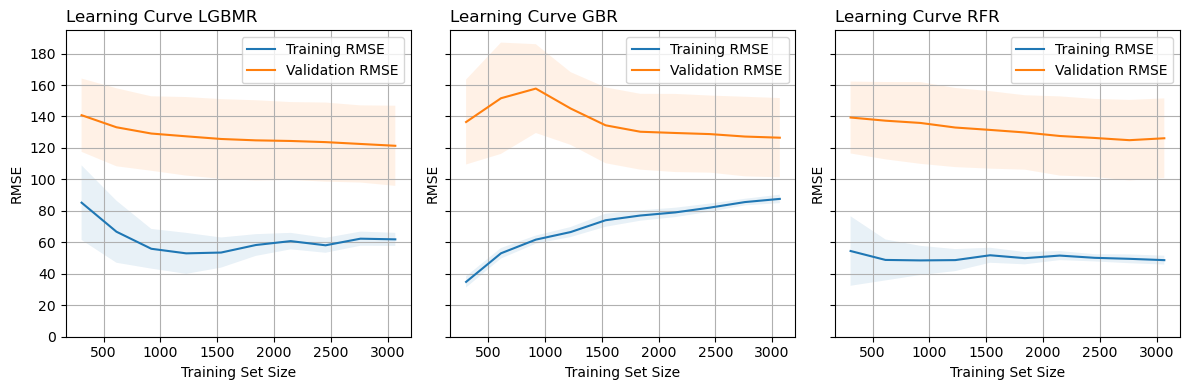

In [76]:
# Plot the learning curve
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)


for i, model_name in enumerate(top3_model_names):
    
    train_sizes, train_mean, test_mean, train_std, test_std = [score_dict[model_name][score] for score in score_dict[model_name]]
    
    ax[i].plot(train_sizes, train_mean, label='Training RMSE')
    ax[i].plot(train_sizes, test_mean, label='Validation RMSE')
    ax[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    ax[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    ax[i].set_xlabel('Training Set Size')
    ax[i].set_ylabel('RMSE')
    ax[i].set_yticks(np.arange(0,200, 20))
    ax[i].set_title(f'Learning Curve {top3_model_names[i]}', loc='left')
    ax[i].legend(loc='best')
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

In [77]:
df_scores_lgbm = pd.DataFrame()

for key, item in score_dict['LGBMR'].items():
    df_scores_lgbm[key] = item

df_scores_lgbm

,train sizes,train mean,test mean,train std,test std
0,306,85.210793,140.822200,23.724121,23.298444
1,613,66.745244,133.147095,19.723471,24.801990
2,920,55.903621,129.161461,12.609201,23.671522
3,1227,52.994878,127.393254,13.027888,24.973448
4,1534,53.508102,125.704615,9.583026,25.333103
5,1840,58.289353,124.827665,6.906983,25.498050
6,2147,60.781594,124.435525,5.237921,24.731137
7,2454,58.114247,123.710042,4.734413,25.146039
8,2761,62.322525,122.540047,4.495047,24.529715
9,3068,61.901010,121.373157,4.141026,25.474126


## Recursive feature elimination with cross validation

In [78]:
# Train/test set generation
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    df.iloc[:, -1],
                                                    test_size=0.2,
                                                    random_state=42)

# Scale train and test sets with StandardScaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

# Init, fit
rfecv = RFECV(
    estimator=LGBMRegressor(),
    min_features_to_select=5,
    step=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    cv=5,
)

_ = rfecv.fit(X_train_std, y_train)

In [79]:
X_train_rfecv = df.iloc[:, :-1].copy()
X_train_rfecv = X_train_rfecv.loc[:, rfecv.support_]

X_train_rfecv.sample(5)

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,beds,availability_90,number_of_reviews,number_of_reviews_ltm,...,amenity_stove,amenity_toaster,amenity_trash_compactor,amenity_tv,amenity_view,amenity_waterfront,amenity_wifi,amenity_window_guards,amenity_wine_glasses,review_scores_mean
2827,1524,1.0,0.92,0,5.0,1,4.0,68,14,12,...,1,1,0,1,0,0,1,0,1,4.570000
3915,1935,1.0,0.99,1,75.0,1,2.0,74,26,26,...,1,1,0,1,1,0,1,0,1,4.965714
4434,3548,1.0,1.00,0,1.0,1,1.0,74,7,7,...,0,0,0,1,0,0,1,0,0,4.571429
1294,1933,1.0,0.99,1,1.0,1,1.0,24,79,33,...,1,0,0,1,1,0,1,0,1,4.814286
808,3570,1.0,1.00,0,1.0,1,3.0,14,4,0,...,1,1,0,1,0,0,1,0,1,4.857143


In [80]:
X_train_rfecv.shape[1]

157

## Plot LGBM learning curve with 157 features

In [81]:
model = LGBMRegressor()
score_dict = {}
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                        X=X_train_rfecv,
                                                        y=df.iloc[:,-1],
                                                        train_sizes=train_sizes,
                                                        cv=5,
                                                        scoring='neg_mean_squared_error',
                                                        shuffle=True)

# Convert the scores to positive values and compute RMSE
train_scores = np.sqrt(-train_scores)
test_scores = np.sqrt(-test_scores)

# Compute the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

score_dict=dict()
score_dict['train sizes'] = train_sizes
score_dict['train mean'] = train_mean
score_dict['test mean'] = test_mean
score_dict['train std'] = train_std
score_dict['test std'] = test_std

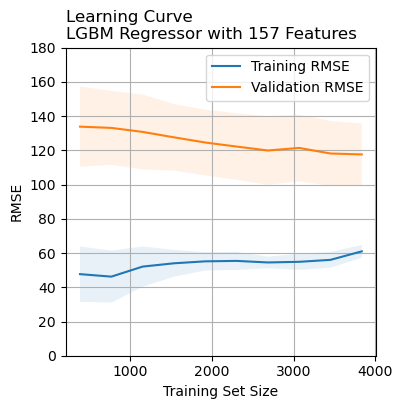

In [82]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(train_sizes, train_mean, label='Training RMSE')
ax.plot(train_sizes, test_mean, label='Validation RMSE')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

ax.set_xlabel('Training Set Size')
ax.set_ylabel('RMSE')
ax.set_yticks(np.arange(0,200,20))
ax.set_title(f'Learning Curve\nLGBM Regressor with {X_train_rfecv.shape[1]} Features', loc='left')
ax.legend(loc='best')
ax.grid(True)

## Tune LGBM regressor

In [83]:
def objective(trial, X, y):
    param_grid = {
        'objective': 'regression',
        'metric': 'rmse', 
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95, step=0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
                   
        model = lgbm.LGBMRegressor(**param_grid)
        
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmse',
                  callbacks=[LightGBMPruningCallback(trial, 'rmse'),
                             lgbm.early_stopping(50)])

        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        cv_scores[idx] = mae

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial,
                               X_train_rfecv, # X
                               df.iloc[:, -1], # y
                              )

study.optimize(func, n_trials=20)

[I 2023-06-28 08:10:55,095] A new study created in memory with name: LGBM Regressor
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is alr

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.7181184609017388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7181184609017388
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[LightGBM] [Warning] lambd

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.149124667910414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.149124667910414
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 270.746
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] lambda_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[75]	valid_0's rmse: 131.66
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.722610666619625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.722610666619625
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[900]	valid_0's rmse: 200.577
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[149]	valid_0's rmse: 153.023
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.722610666619625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.722610666619625
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:49

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[329]	valid_0's rmse: 155.052
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.722610666619625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.722610666619625
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

Early stopping, best iteration is:
[186]	valid_0's rmse: 141.19
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.618761621620817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.618761621620817
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. C

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:49

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 265.757
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.33990374202350293, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33990374202350293
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 270.746
[LightGBM] [Warning] min_d

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's rmse: 89.1155
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.018937846419767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.018937846419767
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[224]	valid_0's rmse: 161.873
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.018937846419767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.018937846419767
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[94]	valid_0's rmse: 113.139
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.018937846419767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.018937846419767
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[103]	valid_0's rmse: 115.864
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.018937846419767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.018937846419767
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Early stopping, best iteration is:
[40]	valid_0's rmse: 110.187
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.769478980578027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.769478980578027
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[1]	valid_0's rmse: 276.869
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=13.06629957735364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.06629957735364
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 265.757
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Cu

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[1]	valid_0's rmse: 270.746
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.576330161809586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.576330161809586
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 91.2773
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.

Did not meet early stopping. Best iteration is:
[383]	valid_0's rmse: 161.224
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.576330161809586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.576330161809586
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[178]	valid_0's rmse: 110.458
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.576330161809586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.576330161809586
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[112]	valid_0's rmse: 114.713
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.576330161809586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.576330161809586
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2023-06-28 08:11:02,571] Trial 12 pruned. Trial was pruned at iteration 51.


Early stopping, best iteration is:
[64]	valid_0's rmse: 109.302
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.410741314802031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.410741314802031
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2023-06-28 08:11:02,676] Trial 13 pruned. Trial was pruned at iteration 51.
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=11.516874510018305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.516874510018305
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 290.095
[LightGBM] [Warning] min_d

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[I 2023-06-28 08:11:03,056] Trial 16 pruned. Trial was pruned at iteration 51.
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=7.429673953607544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.429673953607544
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 276.869
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] lambda_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2023-06-28 08:11:03,312] Trial 18 pruned. Trial was pruned at iteration 51.
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 290.095
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=12.470312636314727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.470312636314727
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 276.

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=5.625577149702778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.625577149702778
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 290.095
[LightGBM] [Warning] min_data_

In [84]:
study.best_params

{'n_estimators': 4000,
 'learning_rate': 0.24636510562239386,
 'num_leaves': 2920,
 'max_depth': 10,
 'min_data_in_leaf': 200,
 'max_bin': 236,
 'lambda_l1': 55,
 'lambda_l2': 50,
 'min_gain_to_split': 11.018937846419767,
 'bagging_fraction': 0.8,
 'feature_fraction': 0.4}

## Plot LGMB regressor learning curve with tuned parameters

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_train_rfecv, # X
                                                    df.iloc[:, -1], # y
                                                    test_size = 0.2 )
# Create the XGBoost model
model = LGBMRegressor(**study.best_params)
# Set the training set sizes for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X_train,
                                                        y_train, 
                                                        train_sizes=train_sizes,
                                                        cv=5,
                                                        scoring='neg_mean_squared_error',
                                                        shuffle=True)

# Convert the scores to positive values and compute RMSE
train_scores = np.sqrt(-train_scores)
test_scores = np.sqrt(-test_scores)

# Compute the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
 
score_dict=dict()
score_dict['train sizes'] = train_sizes
score_dict['train mean'] = train_mean
score_dict['test mean'] = test_mean
score_dict['train std'] = train_std
score_dict['test std'] = test_std

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.018937846419767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.018937846419767
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, co

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.018937846419767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.018937846419767
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, co

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.018937846419767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.018937846419767
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, co

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.018937846419767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.018937846419767
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, co

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.018937846419767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.018937846419767
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.4, co

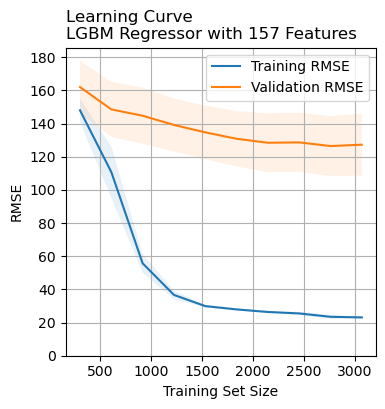

In [86]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(train_sizes, train_mean, label='Training RMSE')
ax.plot(train_sizes, test_mean, label='Validation RMSE')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

ax.set_xlabel('Training Set Size')
ax.set_ylabel('RMSE')
ax.set_yticks(np.arange(0,200, 20))
ax.set_title(f'Learning Curve\nLGBM Regressor with {X_train_rfecv.shape[1]} Features', loc='left')
ax.legend(loc='best')
ax.grid(True)

In [87]:
pd.DataFrame(score_dict)

,train sizes,train mean,test mean,train std,test std
0,306,147.966054,161.963229,7.031419,15.959875
1,613,110.737066,148.537000,15.491429,16.580954
2,920,55.693648,144.703147,5.624846,16.976891
3,1227,36.656547,139.126375,2.585093,16.017963
4,1534,29.912235,134.677919,0.750106,16.146902
5,1840,27.924141,130.805244,0.621064,16.681486
6,2147,26.376091,128.401584,0.564625,17.747302
7,2454,25.497369,128.626805,0.896874,17.934272
8,2761,23.468954,126.419930,1.222430,18.062046
9,3068,23.095397,127.225661,0.584721,18.673094


## Recursive feature elimination for 20 features

In [88]:
# Train/test set generation
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    df.iloc[:, -1],
                                                    train_size=0.2,
                                                    random_state=42)

# Scale train and test sets with StandardScaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

# Init the transformer
rfe = RFE(estimator=LGBMRegressor(), n_features_to_select=20)

# Fit to the training data
_ = rfe.fit(X_train_std, y_train)

In [89]:
X_train_rfe = df.iloc[:, :-1].copy()
X_train_rfe = X_train_rfe.loc[:, rfe.support_]

X_train_rfe.sample(5)

,host_since,host_acceptance_rate,host_listings_count,beds,availability_90,number_of_reviews,number_of_reviews_ltm,first_review,last_review,reviews_per_month,property_type_entire_rental_unit,bathrooms,amenity_beach_essentials,amenity_coffee_maker,amenity_crib,amenity_dedicated_workspace,amenity_elevator,amenity_fireplace,amenity_lockbox,review_scores_mean
1412,3003,1.00,1.0,2.0,3,38,17,1850,11,0.62,1.0,1.0,0,1,0,1,0,0,0,4.980000
3496,3452,1.00,1.0,2.0,30,54,50,385,16,4.20,0.0,1.0,0,0,0,0,0,0,0,4.921429
4584,3985,1.00,27.0,2.0,73,6,6,69,3,2.57,1.0,1.0,0,1,1,0,0,0,1,4.760000
1263,2641,0.97,24.0,3.0,28,224,63,1926,7,3.49,1.0,2.0,0,1,0,0,1,0,0,4.841429
4015,3071,1.00,5.0,4.0,55,25,25,204,4,3.66,0.0,1.0,0,1,1,1,0,1,1,4.891429


## Plot LGBM learning curve with 20 selected features

In [90]:
model = LGBMRegressor()
score_dict = {}
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                        X=X_train_rfe,
                                                        y=df.iloc[:,-1],
                                                        train_sizes=train_sizes,
                                                        cv=5,
                                                        scoring='neg_mean_squared_error',
                                                        shuffle=True)

# Convert the scores to positive values and compute RMSE
train_scores = np.sqrt(-train_scores)
test_scores = np.sqrt(-test_scores)

# Compute the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

score_dict[top3_model_names[i]] = {'train sizes': train_sizes,
                                   'train mean': train_mean,
                                   'test mean': test_mean,
                                   'train std': train_std,
                                   'test std': test_std}

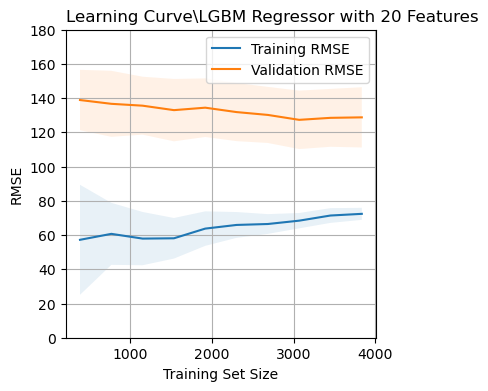

In [91]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(train_sizes, train_mean, label='Training RMSE')
ax.plot(train_sizes, test_mean, label='Validation RMSE')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

ax.set_xlabel('Training Set Size')
ax.set_ylabel('RMSE')
ax.set_yticks(np.arange(0,200, 20))
ax.set_title(f'Learning Curve\LGBM Regressor with {X_train_rfe.shape[1]} Features', loc='left')
ax.legend(loc='best')
ax.grid(True)

## Tune LGBM regressor with 20 features

In [92]:
def objective(trial, X, y):
    param_grid = {
        'objective': 'regression',
        'metric': 'rmse', 
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95, step=0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
                   
        model = lgbm.LGBMRegressor(**param_grid)
        
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmse',
                  callbacks=[LightGBMPruningCallback(trial, 'rmse'),
                             lgbm.early_stopping(50)])

        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        cv_scores[idx] = mae

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial,
                               X_train_rfe, # X
                               df.iloc[:, -1], # y
                              )

study.optimize(func, n_trials=20)

[I 2023-06-28 08:16:52,269] A new study created in memory with name: LGBM Regressor
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is alr

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=5.335005201087366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.335005201087366
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] lambda_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 276.869
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=8.538454322063517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.538454322063517
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 265.757
[LightGBM] [Warning] min_data_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
[I 2023-06-28 08:16:52,679] Trial 4 finished with value: 105.44266730872025 and parameters: {'n_estimators': 9200, 'learning_rate': 0.14847807598286705, 'num_leaves': 1700, 'max_depth': 9, 'min_data_in_leaf': 8300, 'max_bin': 242, 'lambda_l1': 35, 'lambda_l2': 75, 'min_gain_to_split': 5.409470410105712, 'bagging_fraction': 0.7, 'fea

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[1]	valid_0's rmse: 270.746
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=0.26987191499695806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26987191499695806
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

[I 2023-06-28 08:16:52,982] Trial 7 finished with value: 105.44266730872025 and parameters: {'n_estimators': 2100, 'learning_rate': 0.15223741805977833, 'num_leaves': 420, 'max_depth': 6, 'min_data_in_leaf': 8500, 'max_bin': 211, 'lambda_l1': 60, 'lambda_l2': 45, 'min_gain_to_split': 12.805678752524283, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.7}. Best is trial 0 with value: 105.44266730872025.
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.1

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[1]	valid_0's rmse: 270.746
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=12.805678752524283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.805678752524283
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_ch

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
[I 2023-06-28 08:16:53,083] Trial 8 finished with value: 105.44266730872025 and parameters: {'n_estimators': 2100, 'learning_rate': 0.16801987811645344, 'num_leaves': 2540, 'max_depth': 5, 'min_data_in_leaf': 7400, 'max_bin': 278, 'lambda_l1': 35, 'lambda_l2': 70, 'min_gain_to_split': 10.365168623176425, 'bagging_fraction': 0.9, 'feature_fraction': 0.9}. Best is trial 0 with value: 105.44266730872025.
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-package

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=13.434801296089782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.434801296089782
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] lambda_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[285]	valid_0's rmse: 169.819
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.936821956233227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.936821956233227
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[245]	valid_0's rmse: 122.204
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.936821956233227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.936821956233227
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[146]	valid_0's rmse: 121.909
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.936821956233227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.936821956233227
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 113.465
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Curr

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[130]	valid_0's rmse: 96.116
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.067634250972196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.067634250972196
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[474]	valid_0's rmse: 165.927
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.067634250972196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.067634250972196
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

Early stopping, best iteration is:
[141]	valid_0's rmse: 120.99
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.067634250972196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.067634250972196
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[152]	valid_0's rmse: 119.963
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.067634250972196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.067634250972196
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 114.889
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Curr

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2023-06-28 08:16:56,392] Trial 12 pruned. Trial was pruned at iteration 51.
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2023-06-28 08:16:56,490] Trial 13 pruned. Trial was pruned at iteration 51.
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  wa

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2023-06-28 08:16:56,681] Trial 16 pruned. Trial was pruned at iteration 51.
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:49

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.090737663886137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.090737663886137
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 167.028
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.442593828794944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.442593828794944
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 120.156
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.442593828794944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.442593828794944
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Did not meet early stopping. Best iteration is:
[84]	valid_0's rmse: 120.368
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.442593828794944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.442593828794944
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Did not meet early stopping. Best iteration is:
[56]	valid_0's rmse: 114.529
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=10.417287485377923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.417287485377923
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 271.715
[LightGBM] [Warning] min_data_in_leaf is set=

In [93]:
study.best_params

{'n_estimators': 100,
 'learning_rate': 0.2515183477082735,
 'num_leaves': 1340,
 'max_depth': 12,
 'min_data_in_leaf': 200,
 'max_bin': 264,
 'lambda_l1': 0,
 'lambda_l2': 90,
 'min_gain_to_split': 10.442593828794944,
 'bagging_fraction': 0.6000000000000001,
 'feature_fraction': 0.6000000000000001}

## Plot tuned LGBM regressor learning curve with 20 features

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_train_rfe, # X
                                                    df.iloc[:, -1], # y
                                                    test_size = 0.2 )
# Create the XGBoost model
model = LGBMRegressor(**study.best_params)
# Set the training set sizes for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X_train,
                                                        y_train, 
                                                        train_sizes=train_sizes, cv=5,
                                                        scoring='neg_mean_squared_error',
                                                        shuffle=True)

# Convert the scores to positive values and compute RMSE
train_scores = np.sqrt(-train_scores)
test_scores = np.sqrt(-test_scores)

# Compute the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
 
score_dict=dict()
score_dict['train sizes'] = train_sizes
score_dict['train mean'] = train_mean
score_dict['test mean'] = test_mean
score_dict['train std'] = train_std
score_dict['test std'] = test_std

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.442593828794944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.442593828794944
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.442593828794944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.442593828794944
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.442593828794944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.442593828794944
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.442593828794944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.442593828794944
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.442593828794944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.442593828794944
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0


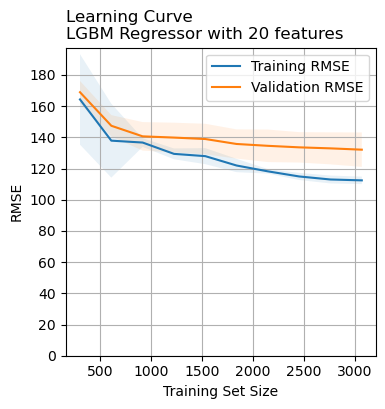

In [95]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(train_sizes, train_mean, label='Training RMSE')
ax.plot(train_sizes, test_mean, label='Validation RMSE')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

ax.set_xlabel('Training Set Size')
ax.set_ylabel('RMSE')
ax.set_yticks(np.arange(0,200, 20))
ax.set_title(f'Learning Curve\nLGBM Regressor with {X_train_rfe.shape[1]} features', loc='left')
ax.legend(loc='best')
ax.grid(True)